In [ ]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Loading the data

In [ ]:
# Loading the data
dataset = panda.read_csv('TwitterDataset.csv')
# dataset.tail(10)

In [ ]:
dataset['class'].hist()

In [ ]:
# The histogram shows that the majority of the tweets are offensive - 1, followed by neutral - 2, and hatred - 0.

In [ ]:
tweet=dataset['tweet']
# print(tweet)

# Preprocessing the data

In [ ]:
#Collecting the stopwords to remove them
stopWords = stopwords.words('english')
# print(stopWords)

In [ ]:
## 1. Removal of punctuation and capitalization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ['#ff', 'ff','rt']
stopWords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # removal of capitalization
    tweet_lower = punc_remove.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopWords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

# All the proccessed tweets are stored into another variable
processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
# dataset['processed_tweets']

# Visualizations

In [ ]:
# visualizing which of the word is most commonly used in the twitter dataset

import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words = ' '.join([text for text in dataset['processed_tweets']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# visualizing which of the word is most commonly used for hate speech
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# visualizing which of the word is most commonly used for offensive speech
offensive_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# visualizing which of the word is most commonly used for neutral speech
neutral_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 2]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(neutral_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Feature Generation

In [ ]:
# Extracting unigram, bigram and trigram features
ngram_vectorizer = CountVectorizer(ngram_range=(1,3),max_df=0.75, min_df=1, max_features=20000)

# bigram feature matrix
ngram = ngram_vectorizer.fit_transform(processed_tweets).toarray()
features=(ngram_vectorizer.get_feature_names())
# print(features)

In [ ]:
#TF-IDF Features
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),max_df=0.75, min_df=5, max_features=20000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] ).toarray()

# Building models using Logistic Regression

In [ ]:
# Using the ngram features extracted

x = panda.DataFrame(ngram)
y = dataset['class'].astype(int)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.25)


model = LogisticRegression(class_weight='balanced',penalty="l2",solver="liblinear", C=0.01).fit(x_train,y_train)
y_preds = model.predict(x_test)
report = classification_report( y_test, y_preds )
print(report)

print("Accuracy Score:" , accuracy_score(y_test,y_preds))

In [ ]:
# Using the TF-IDF features extracted

X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)


model = LogisticRegression(solver='lbfgs',max_iter=1000).fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)

print("Accuracy Score:" , accuracy_score(y_test,y_preds))

In [ ]:
## Sentiment Analysis
sentiment_analyzer = VS()

def count_tags(tweet_c):  
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)
#final_features

new_features = panda.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

In [ ]:
#tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf,final_features],axis=1)
print(modelling_features.shape)

# Running the model Using TFIDF with some features from sentiment analysis

X = panda.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

model = LogisticRegression(max_iter=500).fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)

print("Accuracy Score:" , accuracy_score(y_test,y_preds))


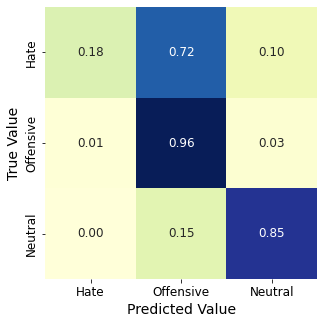

In [21]:
#Confusion Matrix for TFIDF with some features from sentiment analysis
confusionMatrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusionMatrix[i,:]/float(confusionMatrix[i,:].sum())
names=['Hate','Offensive','Neutral']
confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)